In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using Alert

In [11]:
function covariance_S(X::Array{Float64,1},Y::Array{Float64,1})
    n=length(X)
    cov=0
    Xm=mean(X)
    Ym=mean(Y)
    for i=1:n
        cov=(X[i]-Xm)*(Y[i]-Ym) + cov
    end
    return cov/n
end

covariance_S (generic function with 1 method)

In [12]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [13]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [14]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [15]:
function eigenf(tiradas::Int64,PASO::Int64)


    θ=Array{Float64,1}(undef,tiradas)

    for j=1:tiradas

        K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
        T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

        Un=U.(K,T)
        ϕn=ϕ.(K,T,Δt)

        ω=Array{Array{Float64,1},1}(undef,PASO)
        Ψ=Array{Float64,1}(undef,PASO)
        ω[1]=Un[1]
        Ψ[1]=ϕn[1]

        ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
        w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
        ω[2]=w
        Ψ[2]=ψ1
        for i=3:PASO
            ψ=ψn(ψ1,ϕn[i],Un[i],w)
            w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
            ω[i]=w
            Ψ[i]=ψ1
            ψ1=ψ
        end
        θ[j]=Ψ[end]
    end
    return θ
end

eigenf (generic function with 1 method)

In [16]:
function serie_tiempo_θ(PASO);     # Nos da la serie de tiempo de las eigenfases
    θ=Array{Float64,1}(undef,PASO)

    K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
    T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]
    
    θ[1]=Ψ[1]     #Agregamos la primer eigenfase
    
    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    
    θ[2]=Ψ[2]     #Agregamos la segunda eigenfase
    
    for i=3:PASO   #Agregamos LOS demas eigenfases
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        θ[i]=Ψ[i]
    end
    
    return θ
end

serie_tiempo_θ (generic function with 1 method)

In [17]:
k0=0.01
t0=0.01

γK=2.0
γT=2.0

ηK=1.0
ηT=1.0

N=80.0

Δt=0.001

t=0:Δt:N

ctek=3.0
ctet=3.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [18]:
tiradas=500
PASO=length(t)
#PASO=300

80001

In [19]:
@time θ = eigenf(tiradas,PASO);

103.903069 seconds (879.11 M allocations: 23.850 GiB, 4.73% gc time)


In [20]:
Sp=vcat(θ,-θ,zeros(length(θ)))
Sp=angle.(exp.(-im*Sp));

  3.731012 seconds (7.10 M allocations: 366.226 MiB, 3.04% gc time)


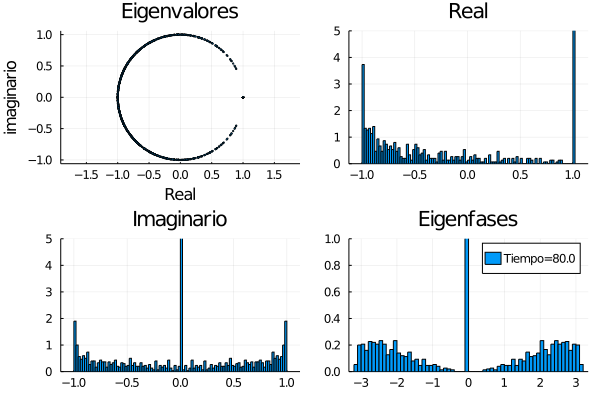

In [21]:
@time begin  
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores")
Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100,ylims=(0,5))
Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100,ylims=(0,5))
Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(t[PASO])",title="Eigenfases",ylims=(0,1),xlims=(-(1*π+0.2),1*π+0.2))
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png");
end

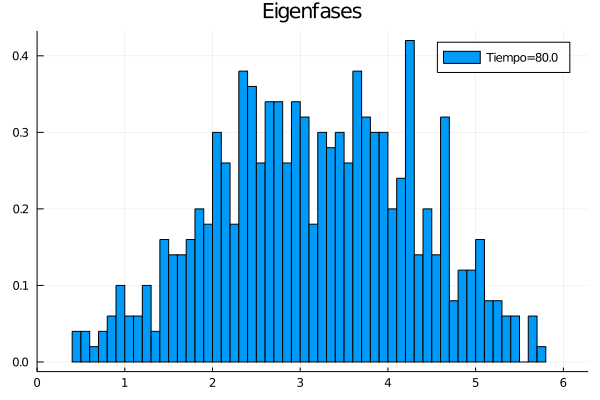

In [22]:
histogram(θ,normalized=true,bins=60,label="Tiempo=$(t[PASO])",title="Eigenfases",xlims=(0,2*π))


In [13]:
#savefig("./Eigen_fases_paso_3.png")

In [14]:
step=100
tiradas=100
a=2:step:length(t)

2:100:54902

 35.494202 seconds (262.80 M allocations: 7.365 GiB, 2.97% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\CODIGOS FINALES\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_5.0ct=5.0.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\SIQaY\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\CODIGOS FINALES\\Animacion_Prueba_3D_gamK=2.0_gam=2.0_etaK=1.0_etaT=1.0_k0=0.01_t0=0.01_ck=_5.0ct=5.0.gif")
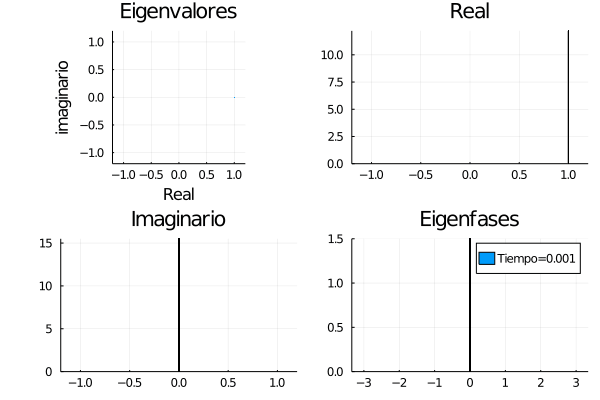

In [34]:
@time begin    
    anim= @animate for j=2:step:length(t)
        θ = eigenf(tiradas,j);
        Sp=vcat(θ,-θ,zeros(length(θ)))
        Sp=angle.(exp.(-im*Sp))
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q1=scatter(real(exp.(-im*Sp)),imag(exp.(-im*Sp)),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="Eigenvalores",xlims=(-1.2,1.2),ylims=(-1.2,1.2))
        Q2=histogram(real(exp.(-im*Sp)),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,12.2))
        Q3=histogram(imag(exp.(-im*Sp)),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.2,1.2),ylims=(0,15.5))
        Q4=histogram(Sp,normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfases",xlims=(-(1*π+0.2),1*π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).gif", fps=60)
end

In [29]:
PASO=length(t)

80001

In [30]:
@time serie_tiempo_θ(PASO);

  0.206230 seconds (1.76 M allocations: 49.393 MiB)


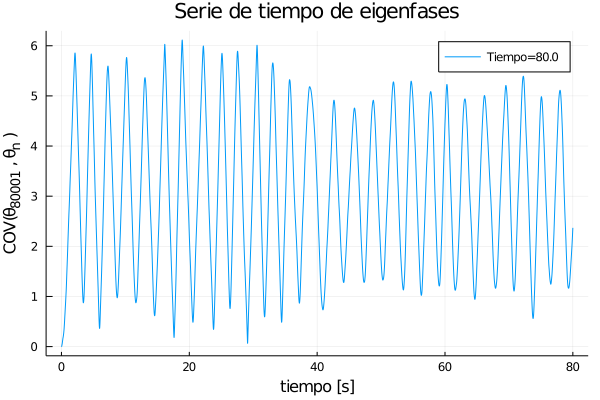

In [31]:
plot(t[1:PASO],serie_tiempo_θ(PASO),label="Tiempo=$(t[PASO])",
    title="Serie de tiempo de eigenfases",xlabel="tiempo [s]",ylabel="COV\\(\\theta_{$(PASO)} , \\theta_{n} \\)")

In [32]:
A=[]
for i=1:500
    push!(A,serie_tiempo_θ(PASO))
end

In [33]:
@time covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,1001])

  0.341317 seconds (387.76 k allocations: 630.506 MiB, 12.08% gc time)


0.18763530222008157

In [34]:
length(1000:5:length(t))

15801

In [ ]:
OH=Float64[]
for i=1000:5:length(t)
    a=covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,i])
    push!(OH,a)
end

In [ ]:
plot(t[1000:5:length(t)],OH,title="Covarianza")

In [67]:
savefig("./COVARIANCE4.png")

In [12]:
length(t)

55001

In [14]:
tiradas=500
PASO=50001
steps=50
length(0:steps:length(t)-PASO)

101

In [15]:
length(t)-PASO

5000

In [16]:
t_0=Float64[]
for i=0:steps:length(t)-PASO
    push!(t_0,t[PASO+i])
end

In [17]:
@time θ1=eigenf(tiradas,PASO);

 62.322442 seconds (548.49 M allocations: 14.879 GiB, 3.76% gc time)


In [18]:
@time begin  
    cvat=Float64[]
    for i=0:steps:length(t)-PASO
        θ2 = eigenf(tiradas,PASO+i);
        push!(cvat,cov(θ1,θ2))
    end
end

6527.931478 seconds (58.17 G allocations: 1.541 TiB, 3.65% gc time)


In [19]:
cvat

101-element Array{Float64,1}:
  0.07982010985027178
  0.035678505639134626
 -0.02201347156638121
  0.0632216789017488
 -0.08528059938138494
 -0.04740353067129501
  0.033809969774190776
  0.029873445230138455
 -0.006687846280765698
 -0.03121469477046399
  0.07958024061148056
 -0.02684879683270414
 -0.06811263732454813
  ⋮
 -0.030044127085215155
  0.020301997778121063
  0.07541956591530585
  0.00011059890728263784
  0.04390939481759228
 -0.07678642894649225
 -0.0010665298342836928
  0.0013698943463648099
 -0.04983578531133689
 -0.08001705615428922
  0.03294292203301945
  0.06646011857520143

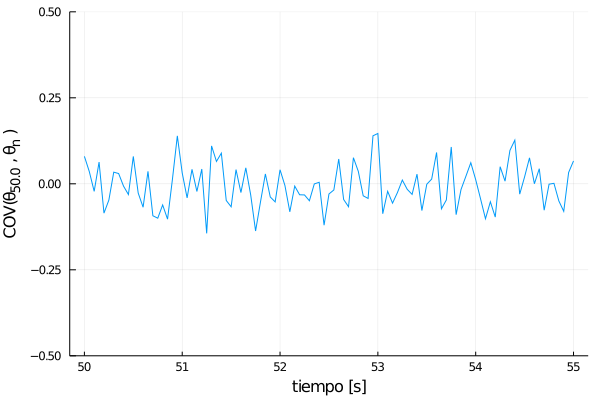

In [20]:
plot(t_0,cvat, ylims=(-0.5,0.5),legend=false,xlabel="tiempo [s]",ylabel="COV\\(\\theta_{$(t[PASO])} , \\theta_{n} \\)")

In [21]:
savefig("./COVARIANCE4.png")

In [78]:
t0=Float64[]
for i=0:100:30000
    push!(t0,t[PASO+i])
end

In [79]:
t0

301-element Array{Float64,1}:
 50.0
 50.1
 50.2
 50.3
 50.4
 50.5
 50.6
 50.7
 50.8
 50.9
 51.0
 51.1
 51.2
  ⋮
 78.9
 79.0
 79.1
 79.2
 79.3
 79.4
 79.5
 79.6
 79.7
 79.8
 79.9
 80.0

In [76]:
[1,2,2.0]

3-element Array{Float64,1}:
 1.0
 2.0
 2.0

In [11]:
cov(θ1,θ1)

0.00043561245213045703

In [12]:
var(θ1)

0.00043561245213045725

In [19]:
t[50001]

50.0

In [20]:
t[end]

80.0

In [52]:
var(θ1)

1.3834086048725083

In [29]:
var(randn(10000))

0.9978476518330084

In [50]:
t[50001]

50.0

In [56]:
length(t)-50001

30000

In [57]:
30000+50001

80001

In [59]:
a=0:10

0:10

In [60]:
a[1]

0

In [13]:
? cov()

```
cov(x::AbstractVector; corrected::Bool=true)
```

Compute the variance of the vector `x`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = length(x)`.

---

```
cov(X::AbstractMatrix; dims::Int=1, corrected::Bool=true)
```

Compute the covariance matrix of the matrix `X` along the dimension `dims`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = size(X, dims)`.

---

```
cov(x::AbstractVector, y::AbstractVector; corrected::Bool=true)
```

Compute the covariance between the vectors `x` and `y`. If `corrected` is `true` (the default), computes $\frac{1}{n-1}\sum_{i=1}^n (x_i-\bar x) (y_i-\bar y)^*$ where $*$ denotes the complex conjugate and `n = length(x) = length(y)`. If `corrected` is `false`, computes $\frac{1}{n}\sum_{i=1}^n (x_i-\bar x) (y_i-\bar y)^*$.

---

```
cov(X::AbstractVecOrMat, Y::AbstractVecOrMat; dims::Int=1, corrected::Bool=true)
```

Compute the covariance between the vectors or matrices `X` and `Y` along the dimension `dims`. If `corrected` is `true` (the default) then the sum is scaled with `n-1`, whereas the sum is scaled with `n` if `corrected` is `false` where `n = size(X, dims) = size(Y, dims)`.

---

```
cov(X, w::AbstractWeights, vardim=1; mean=nothing,  corrected=false)
```

Compute the weighted covariance matrix. Similar to `var` and `std` the biased covariance matrix (`corrected=false`) is computed by multiplying `scattermat(X, w)` by $\frac{1}{\sum{w}}$ to normalize. However, the unbiased covariance matrix (`corrected=true`) is dependent on the type of weights used:

  * `AnalyticWeights`: $\frac{1}{\sum w - \sum {w^2} / \sum w}$
  * `FrequencyWeights`: $\frac{1}{\sum{w} - 1}$
  * `ProbabilityWeights`: $\frac{n}{(n - 1) \sum w}$ where $n$ equals `count(!iszero, w)`
  * `Weights`: `ArgumentError` (bias correction not supported)

---

```
cov(ce::CovarianceEstimator, x::AbstractVector; mean=nothing)
```

Compute a variance estimate from the observation vector `x` using the  estimator `ce`.

---

```
cov(ce::CovarianceEstimator, x::AbstractVector, y::AbstractVector)
```

Compute the covariance of the vectors `x` and `y` using estimator `ce`.

---

```
cov(ce::CovarianceEstimator, X::AbstractMatrix, [w::AbstractWeights]; mean=nothing, dims::Int=1)
```

Compute the covariance matrix of the matrix `X` along dimension `dims` using estimator `ce`. A weighting vector `w` can be specified. The keyword argument `mean` can be:

  * `nothing` (default) in which case the mean is estimated and subtracted from the data `X`,
  * a precalculated mean in which case it is subtracted from the data `X`. Assuming `size(X)` is `(N,M)`, `mean` can either be:

      * when `dims=1`, an `AbstractMatrix` of size `(1,M)`,
      * when `dims=2`, an `AbstractVector` of length `N` or an `AbstractMatrix` of size `(N,1)`.

---

```
cov(d::MultivariateDistribution)
```

Compute the covariance matrix for distribution `d`. (`cor` is provided based on `cov`).

---

```
cov(d::MatrixDistribution)
```

Compute the covariance matrix for `vec(X)`, where `X` is a random matrix with distribution `d`.

---

```
cov(d::MatrixDistribution, flattened = Val(false))
```

Compute the 4-dimensional array whose `(i, j, k, l)` element is `cov(X[i,j], X[k, l])`.
